In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
%matplotlib inline

In [5]:
adni = pd.read_csv('../database_split/database_info/ADNI_data_information.csv')
adni = adni[['Subject ID', 'Research Group', 'Image Filename', 'MMSE Total Score']]
adni['Image Filename'] = adni['Image Filename'].apply(lambda x: x.split(".nii")[0])

In [3]:
cn = pd.read_csv('../predict_results/test_exp_LR.csv', sep=',')
cn['Research Group'] = 'CN'
ad = pd.read_csv('predict_results/ad_images_LR.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('predict_results/mci_images_LR.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
results = results[['Name', 'True', 'Pred', 'Research Group']]
results.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

In [4]:
data = adni.merge(results, on=['Image Filename', 'Research Group']).reset_index(drop=True)
data.columns = ['Subject ID', 'group', 'Image Filename', 'MMSE', 'Chronological age', 'Estimated age']
data['Delta'] = data[['Chronological age', 'Estimated age']].apply(lambda x: x['Estimated age'] - x['Chronological age'], axis=1)
data.head()

,Subject ID,group,Image Filename,MMSE,Chronological age,Estimated age,Delta
0,035_S_0555,CN,035_S_0555_ADNI1GO_Month_6,30.0,77.7,80.460810,2.760810
1,013_S_0502,CN,013_S_0502_ADNI_Screening,29.0,75.1,71.834617,-3.265383
2,031_S_4032,CN,031_S_4032_ADNI2_Month_6-New_Pt,29.0,70.9,71.768250,0.868250
3,100_S_0035,CN,100_S_0035_ADNI_Screening,30.0,77.0,73.686615,-3.313385
4,129_S_4396,CN,129_S_4396_ADNI2_Year_1_Visit,29.0,79.5,73.095785,-6.404215


           n         r         CI95%        r2    adj_r2     p-val       BF10  \
pearson  151  0.382853  [0.24, 0.51]  0.146577  0.135044  0.000001  1.173e+04   

            power  
pearson  0.998473  
<ipython-input-5-f1474828218f>:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


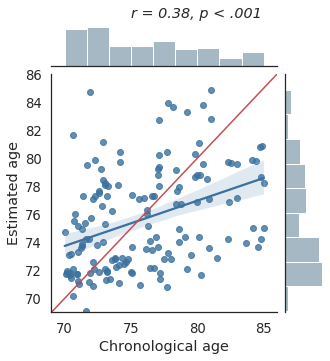

In [5]:

sns.set(style='white', font_scale=1.2)
dt = data[data.group=='CN']
pearson = pg.corr(dt['Estimated age'], dt['Chronological age'])
print(pearson)
g = sns.JointGrid(data=dt, x='Chronological age', y='Estimated age',
                  xlim=(69, 86), ylim=(69, 86), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(75, 90, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()

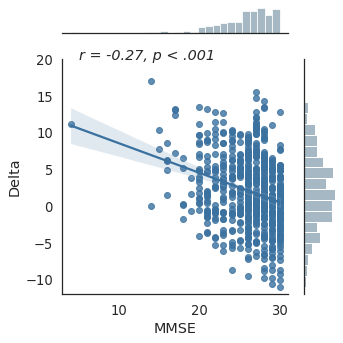

In [6]:

sns.set(style='white', font_scale=1.2)
pearson = pg.corr(data.MMSE, data.Delta)
g = sns.JointGrid(data=data, x='MMSE', y='Delta', xlim=(3, 31), ylim=(-12, 20), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(5, 20, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
plt.tight_layout()

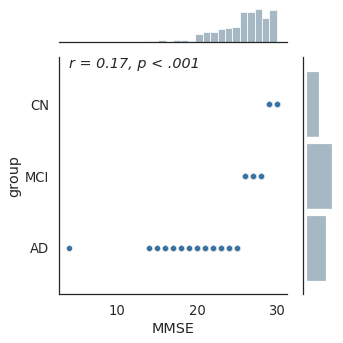

In [7]:
data['id'] = data.group.apply(lambda x: 1 if x=='AD' else 2 if x=='CN' else 0)
pearson = pg.corr(data.MMSE, data.id)
g = sns.JointGrid(data=data, x='MMSE', y='group', height=5)
g.plot_joint(sns.scatterplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(4, -.5, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
plt.tight_layout()

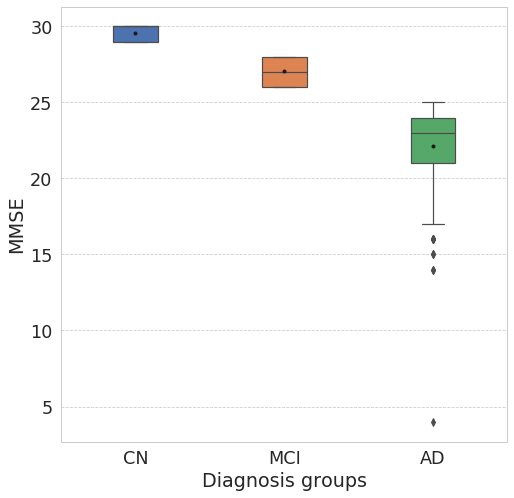

In [8]:
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=2.0, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['MMSE', 'group']]
dt.columns = ['MMSE', 'Diagnosis groups']
sns.boxplot(x="Diagnosis groups", y="MMSE", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
# plt.savefig("groups_boxplot_var.pdf", bbox_inches='tight')


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,67,0.928346,"[0.89, 0.96]",0.861826,0.857508,1.227232e-29,1.93e+26,1.0


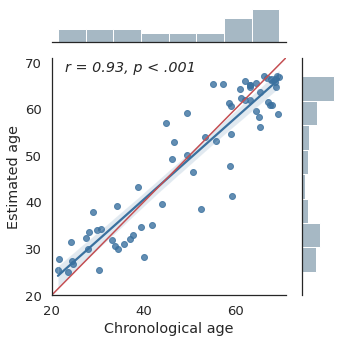

In [11]:
val = pd.read_csv('../predict_results/test_0-70_LR.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)

sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_LR.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,67,0.900675,"[0.84, 0.94]",0.811215,0.805315,3.211556e-25,1.034e+22,1.0


False


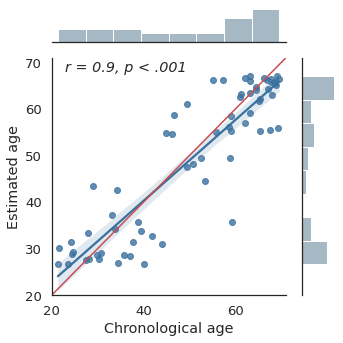

In [15]:
val = pd.read_csv('../predict_results/test_0-70_L.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'], tail='two-sided')
display(pearson)
print(pearson['p-val'][0] > 0.01)
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_L.pdf", bbox_inches='tight', dpi=300)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,67,0.900897,"[0.84, 0.94]",0.811615,0.805728,2.996614e-25,1.106e+22,1.0


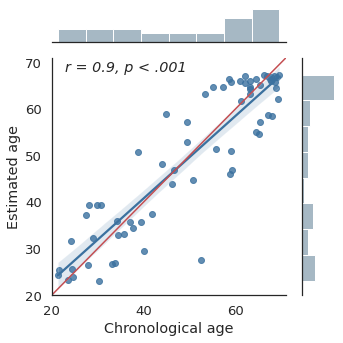

In [10]:
val = pd.read_csv('../predict_results/test_0-70_R.csv', sep=',')
val['Research Group'] = 'CN'
val = val[['Name', 'True', 'Pred', 'Research Group']]
val.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']

pearson = pg.corr(val['Estimated age'], val['Chronological age'])
display(pearson)

sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=val, x='Chronological age', y='Estimated age',
                  xlim=(20, 71), ylim=(20, 71), height=5)
g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
g.ax_joint.text(23, 68, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '-r')
plt.tight_layout()
plt.savefig("correlation_0-70_R.pdf", bbox_inches='tight', dpi=300)